In [2]:
import pandas as pd
import numpy as np

## My data looks like this

| Ticker  | Investmentname. | Quarter | shares | Value
| ------  | -----------------  | --------| ------ | -------
| MSFT  | Something Capital|12/31/2019| 1000| $250000
| AAPL  | Blah Capital.          | 3/30/2018 |2000| $500000

I am not trying to solve particular problem. Theoretically the problem that everyone in finance is trying to solve is predict future returns, but there are too many inputs that you can look at, so it's better to find something that you can predict and then see if its useful. The reason I am looking at collaborative filtering and recommendation system is that when I try to describe how institutional stock ownership works in terms that are used in the recommendation systems framework, it does not sound ridiculous and also it might be possible to add pieces on top of it in a way that makes sense.
Things that it might be possible to predict would be something like, 
- when the leading economic indicators are changing direction, what are the chances that institutional investors change their allocation to a particular stocks. 
- based on the current ownership what are the probabilities that certain funds will buy or sell particular stocks unconditiionally or if there is positive or negative surprise on earnings or some other event

The simple model for movie recommendations is:
$$r=p_i^T*q_j$$

where $p_i$ is the feature vector for the user and $q_j$ is the feature vector for the movie
the netflix project winning paper also added a bias for each user and also a function of time as well as other variables.


The straight forward translation of the model is there is a set of features that determine whether fund managers like the stock. example of features that i can think of are:
1. The stock is in S&P500. some funds will buy it just so they can track S&P 500
2. The stock is an energy stock and we are in a year like 2013 when the shale production oil production was growing but it was not that big, so there were a lot of stories about how the oil companies would make money and institutional ownership was high.

The complicating features, which make me relatively sure the most simple model won't work are the following:
1. Movie popularity might vary over time, and thats why the netflix paper has the time function built in, but its basically  still the same movie, and the features that movies have and users value are also somewhat stationary over time.
   With stocks its different, a stock that's cheap in 2012, might have gone up 100% and is expensive in 2014. so if cheapness was a feature of the stock and why people liked it at the time, it might the oppositve now.
   On the demand side, when leading economic are about to trend down, funds might move from industrials and energy into utilities, or staples, so even if the stocks are the same the preference changes. This issue is basically why I don't think i can even test the simple model on actual data, I am generating a synthetic data set first, and then I will have to figure out some way to combine the information about the stock and the quarter and the valuation in a way that makes sense.
2. The data is with delay, the investor file at the end of the quarter, but they actually bought at some point during the quarter. So there is some uncertainty of what the price and the market environment was when they made the decision, also if several funds bought the same stock, it's not possible to tell which one did first if they did it in the same quarter. These are all not immediate issues, they should make prediction quality less, but there should be a way to do something reasonable. Like if I want to add something with valuation, I would have to keep track of the min and max during the quarter.
3. Movie ratings are numeric on the same scale for everyone. On the other hand the funds will have different allocation strategies, some funds will have a small number of stocks like 10 or 20. some funds will basically own almost everything in an index but they will be underweight or overweight particular stocks relative to the index, so that they can beat their benchmark. Also the size depends on how liquid the stock is compared to the size of the fund, and also how big they think the downside risk is. In addition they don't empty their portfolio and start from scratch every quarter, so it might be that the change in the holdings will be more relevant than the total amount of each stock. This is also less important than the first issue but probably needs to be addressed right after.

Synthetic data:
I tried to come up with a simple model that would work for the first iteration of the algo, because I don't think it will do anything reasonable until I add valuation and other information. 

Basically there are some number of stocks and some number of funds. Half of the funds pick stocks based on returns.
Half of them (a quarter of total) pick the stocks that went up the most, the other half pick the stocks that went down the most. I did random picks with probability weighted by returns so the allocations are different.

The other half of the funds pick based on the analyst ratings, half of them pick highest rated stocks and half of them pick lowest. 

Both the ratings and returns are random and won't be inputs to the model,  the question will be if the model can infer those two features.




In [3]:
def pick_stocks(returns, n):
    """
    Picks n stocks with probabilities proportional to their returns.

    :param returns: A 1D numpy array representing the returns of each stock.
    :param n: The number of stocks to pick.
    :return: A list of picked stock indices.
    this is a chatGPT function
    """
    # Normalize the returns to create a probability distribution
    returns = np.array(returns)
    returns = returns - np.min(returns)  # Shift the returns to make them non-negative
    probabilities = returns / np.sum(returns)

    # Pick n stocks using the numpy.random.choice() function
    picked_indices = np.random.choice(len(returns), size=n, replace=False, p=probabilities)
    
    return picked_indices, probabilities

returns = [-.15, 0.10, 0.02, 0.15, 0.03, 0.08, 0.12]
n = 3

picked_indices,probabilities = pick_stocks(returns, n)
print(f"Picked stock indices: {picked_indices}")

probabilities

Picked stock indices: [3 2 6]


array([0.        , 0.17857143, 0.12142857, 0.21428571, 0.12857143,
       0.16428571, 0.19285714])

In [4]:
import numpy as np

def pick_stocks_rank(returns, n):
    """
    Picks n stocks with probabilities proportional to the rank of their returns.

    :param returns: A 1D numpy array representing the returns of each stock.
    :param n: The number of stocks to pick.
    :return: A list of picked stock indices.
    another chatGPT function this one is based on rank instead of return
    """
    # Get the rank of the returns
    sorted_indices = np.argsort(returns)
    ranks = np.empty_like(sorted_indices)
    ranks[sorted_indices] = np.arange(len(returns))

    # Normalize the ranks to create a probability distribution
    probabilities = ranks / np.sum(ranks)

    # Pick n stocks using the numpy.random.choice() function
    picked_indices = np.random.choice(len(returns), size=n, replace=False, p=probabilities)
    
    return picked_indices,probabilities

returns = [0.05, 0.10, 0.02, 0.15, 0.03, 0.08, 0.12]
n = 3

picked_indices,probabilities = pick_stocks_rank(returns, n)
print(f"Picked stock indices: {picked_indices}")
probabilities
#type(picked_indices)

Picked stock indices: [1 6 5]


array([0.0952381 , 0.19047619, 0.        , 0.28571429, 0.04761905,
       0.14285714, 0.23809524])

In [5]:
def pick_stocks_on_preference(num_picks,pref_factor1,pref_factor2,returns,ratings):
    """
    Picks n stocks with probabilities depending on their returns and ratings.
    inputs:
    pref_factor1 - weight of returns
    pref_factor2 - weight of ratings
    only one of the two pref_factors is non-zero
    returns - a numpy array of returns (num_dates,num_stocks)
    ratings - a numpy array of ratings (num_dates,num_stocks)
    num_picks - number of stocks to pick
    outputs:
    picked_indices - a numpy array of the indices of the picked stocks, dimensions are (num_dates,num_picks)
    if pref_factor1 is non-zero, if pref_factor1 is -1 then pick the stocks with the lowest returns
    if pref_factor1 is 1 then pick the stocks with the highest returns
    if pref_factor2 is non-zero, if pref_factor2 is -1 then pick the stocks with the lowest ratings
    if pref_factor2 is 1 then pick the stocks with the highest ratings
    """
    num_dates=returns.shape[0]
    num_stocks=returns.shape[1]
    picked_indices=np.zeros((num_dates,num_picks))
    #print (f'num_picks={num_picks},pref_factor1={pref_factor1},pref_factor2={pref_factor2},num_dates={num_dates},num_stocks={num_stocks}')
    if pref_factor1!=0:
        if pref_factor1==-1:
            #pick stocks based on returns
            for i in range(num_dates):
                picked_indices[i,:],probabilities=pick_stocks_rank(-returns[i,:],num_picks)
                #print(f'picks={picks},probabilities={probabilities}')
        elif pref_factor1==1:
            for i in range(num_dates):
                picked_indices[i,:],probabilities=pick_stocks_rank(returns[i,:],num_picks)
    elif pref_factor2!=0:
        #pick stocks based on ratings
        if pref_factor2==-1:
            for i in range(num_dates):
                picked_indices[i,:],probabilities=pick_stocks_rank(-ratings[i,:],num_picks)
        elif pref_factor2==1:
            for i in range(num_dates):
                picked_indices[i,:],probabilities=pick_stocks_rank(ratings[i,:],num_picks)
    return picked_indices


        




In [7]:
#Create a synthetic data set.  This is a dataframe with 3 columns: ticker, calendardate, investorname, and 1 column: value
#input variables are num_tickers, num_dates, num_investors
#1 generate the date, ticker, and investorname dimensions
#1a generate the date dimension: this should be quarterly dates from starting in 3/30/2009 and going by quarters with num_dates points
#1b generate the ticker dimension: this should be num_tickers tickers
#1c generate the investorname dimension: this should be num_investors investor names

num_tickers = 200
num_dates = 10
num_investors = 100
num_picks = 20

#1a generate the date dimension: this should be quarterly dates from starting in 3/30/2009 and going by quarters with num_dates points
#1b generate the ticker dimension: this should be num_tickers tickers
#1c generate the investorname dimension: this should be num_investors investor names

dim_dates=pd.date_range(start='3/30/2009', periods=num_dates, freq='Q') 
dim_tickers=['ticker'+str(i) for i in range(num_tickers)]
dim_investors=['investor'+str(i) for i in range(num_investors)]


#assign the preference to factor 1 or factor 2 to each fund.
#quarter of the funds have a positive preference to factor 1, quarter of the funds have a negative preference to factor 1, 
#quarter of the funds have a positive preferenc to factor 2, quarter of the funds have a negative preference to factor 2
#the preference is either -1, or 1
#the preference is stored in a separate numpy array called pref_factor1 and pref_factor2

#pref_factor1=(np.random.randint(-1,1,num_tickers)+.5)*2
#pref_factor2=(np.random.randint(-1,1,num_tickers)+.5)*2
#now we need to zero out the preferences for half the funds

#pref_factor1[:int(num_tickers/2)]=0
#pref_factor2[int(num_tickers/2):]=0
pref_factor1=np.zeros(num_investors)
pref_factor2=np.zeros(num_investors)
pref_factor1[:int(num_investors/4)]=-1
pref_factor1[int(num_investors/4):int(num_investors/2)]=1
pref_factor2[int(num_investors/2):int(num_investors*.75)]=-1
pref_factor2[int(num_investors*.75):]=1


#2 generate the synthetic data set
#2a generate the two factors: factor1 and factor2
# factor 1 is momentum/mean_reversion, factor2 is analyst sentiment
#to generate factor 1, we will generate a random walk with mean 0 and std sigma
#half the funds will use this factor, 

sigma=.3
factor1=np.random.normal(0,sigma*.25,(num_dates,num_tickers))
returns=factor1
factor1
factor2=np.random.randint(-2,3,(num_dates,num_tickers))
ratings=factor2

#2b there are two factors and two preferences for each fund.  The preference is either -1 or 1.  The preference is stored in pref_factor1 and pref_factor2
#2c for each of the four combination generate a 2d array of stock indeces for each fund. 
# for factor 1 the probability of picking a stock is proportional to factor
df_out=pd.DataFrame(columns=['ticker','investorname','calendardate','value'])
row_list_dict=[]
for investor in range(num_investors):
    f1=pref_factor1[investor]
    f2=pref_factor2[investor]
    inv_portfolio=pick_stocks_on_preference(num_picks,f1,f2,returns,ratings)
    for d in range(num_dates):
        for s in range(num_picks):
            dict_entry={'ticker':dim_tickers[int(inv_portfolio[d,s])],'investorname':dim_investors[investor],'calendardate':dim_dates[d],'value':1}
            row_list_dict.append(dict_entry)
df_out=pd.DataFrame(row_list_dict)


df_out[df_out['investorname']=='investor1']
df_out.to_csv("synth_data1/synth_data1.csv")
df_positive=df_out


In [8]:
df_out
#dim_tickers

,ticker,investorname,calendardate,value
0,ticker102,investor0,2009-03-31,1
1,ticker101,investor0,2009-03-31,1
2,ticker56,investor0,2009-03-31,1
3,ticker111,investor0,2009-03-31,1
4,ticker176,investor0,2009-03-31,1
...,...,...,...,...
19995,ticker114,investor99,2011-06-30,1
19996,ticker147,investor99,2011-06-30,1
19997,ticker125,investor99,2011-06-30,1
19998,ticker46,investor99,2011-06-30,1


Create a dataset with entries for zeros, alternative is to use contrasting learning

In [9]:
unique_tickers =df_out['ticker'].unique()
unique_investor_names = df_out['investorname'].unique()
unique_calendar_dates = df_out['calendardate'].unique()

unique_calendar_dates=dim_dates
unique_tickers=dim_tickers
unique_investor_names=dim_investors

# Create a new DataFrame with all possible combinations of ticker, investorname, and calendardate
all_combinations = pd.MultiIndex.from_product([unique_tickers, unique_investor_names, unique_calendar_dates],
                                              names=['ticker', 'investorname', 'calendardate']).to_frame(index=False)

# Merge the new DataFrame with your existing DataFrame
merged_data = all_combinations.merge(df_out, on=['ticker', 'investorname', 'calendardate'], how='left')

# Fill in the missing values (i.e., zero holdings) with zeros
merged_data['value'].fillna(0, inplace=True)
len(merged_data)

200000

In [295]:
len(merged_data)

200000

In [10]:
#can run instead of the previous cell
import random

unique_calendar_dates=dim_dates
unique_tickers=dim_tickers
unique_investor_names=dim_investors
# Drop unwanted columns
dim_tickers_dates=[(ticker,dt) for ticker in dim_tickers for dt in dim_dates]
df_train = df_out[['ticker', 'calendardate', 'investorname']]

# Replace 'value' column with 1
df_train['value'] = 1

# Length of dataframe
print('Length of dataframe:', len(df_train))

# Generate list of tuples from df_train for checking existence later
existing_combinations = set(tuple(x) for x in df_train[['ticker', 'calendardate', 'investorname']].to_numpy())

# Generate new list of dictionaries
new_data = []
for _ in range(len(df_train)):
    while True:
        ticker_date = random.choice(dim_tickers_dates)
        investor = random.choice(dim_investors)
        combination = (ticker_date[0], ticker_date[1], investor)
        if combination not in existing_combinations:
            new_data.append({
                'ticker': combination[0],
                'calendardate': combination[1],
                'investorname': combination[2],
                'value': 0
            })
            break

# Convert list of dictionaries to DataFrame
df_new = pd.DataFrame(new_data)

# Append new DataFrame to original DataFrame
df_train = pd.concat([df_train, df_new], ignore_index=True)
df_out=df_train

Length of dataframe: 20000


In [297]:
df_out['ticker'].unique()

array(['ticker20', 'ticker196', 'ticker161', 'ticker111', 'ticker1',
       'ticker61', 'ticker131', 'ticker164', 'ticker138', 'ticker166',
       'ticker141', 'ticker76', 'ticker32', 'ticker79', 'ticker139',
       'ticker185', 'ticker142', 'ticker98', 'ticker145', 'ticker54',
       'ticker89', 'ticker108', 'ticker36', 'ticker17', 'ticker147',
       'ticker31', 'ticker23', 'ticker74', 'ticker135', 'ticker175',
       'ticker169', 'ticker21', 'ticker149', 'ticker41', 'ticker134',
       'ticker129', 'ticker94', 'ticker148', 'ticker191', 'ticker182',
       'ticker5', 'ticker114', 'ticker93', 'ticker14', 'ticker43',
       'ticker181', 'ticker11', 'ticker29', 'ticker163', 'ticker30',
       'ticker130', 'ticker193', 'ticker190', 'ticker84', 'ticker24',
       'ticker100', 'ticker65', 'ticker165', 'ticker3', 'ticker75',
       'ticker115', 'ticker96', 'ticker192', 'ticker162', 'ticker187',
       'ticker136', 'ticker133', 'ticker107', 'ticker126', 'ticker70',
       'ticker195', 'ticke

In [11]:
df_train['value'].sum()
len(df_train)

40000

In [12]:
from sklearn.model_selection import train_test_split
#pick the dataset
#df_out=merged_data

# Split the DataFrame into training and test sets

train_df, test_df = train_test_split(df_out, test_size=0.2, random_state=42)

# Split the training set further into training and validation sets
train_df, val_df = train_test_split(train_df, test_size=0.25, random_state=42)
file_endings=['train','val','test']
for (df,file_ending) in zip([train_df,val_df,test_df],file_endings):
    df.to_csv("synth_data1/synth_data1_"+file_ending+".csv")

# Now you have train_df, val_df, and test_df as your training, validation, and test sets, respectively

This could be split into a different notebook

In [13]:
# Custom dataset class

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader


class SF3Dataset(Dataset):
    def __init__(self, sf3, investor2idx, ticker2idx, date2idx,ticker_date2idx):
        self.sf3 = sf3
        self.investor2idx = investor2idx
        self.ticker2idx = ticker2idx
        self.date2idx = date2idx
        self.ticker_date2idx = ticker_date2idx

    def __len__(self):
        return len(self.sf3)

    def __getitem__(self, idx):
        row = self.sf3.iloc[idx]
        #print(f'__getitem__ row={row}')
        row=row.to_dict()
        #print(f'__getitem__ row={row}')
        investor_idx = self.investor2idx[row['investorname']]
        #print (f'investor_idx={investor_idx}')
        stock_idx = self.ticker2idx[row['ticker']]
        date_idx = self.date2idx[row['calendardate']]
        ticker_date2idx=self.ticker_date2idx[(row['ticker'],row['calendardate'])]
        target = torch.tensor(float(row['value']), dtype=torch.float)
        #print(f'investor_idx={investor_idx}, stock_idx={stock_idx}, date_idx={date_idx}, target={target}')
        return investor_idx, stock_idx, date_idx, ticker_date2idx ,target
    

# Custom collate_fn

def sf3_collate_fn(batch):
    #print(f'batch={batch}')
    investor_list = []
    stock_list = []
    date_list = []
    target_list = []
    for investor, stock, date, target in batch:
        investor_list.append(investor)
        stock_list.append(stock)
        date_list.append(date)
        target_list.append(target)
    return torch.tensor(investor_list), torch.tensor(stock_list), torch.tensor(date_list), torch.tensor(target_list)

# Create the dataset and dataloader

    

In [17]:
# Define the model
import torch.nn.init as init


class MatrixFactorization(nn.Module):
    def __init__(self, num_investors, embedding_dim, num_tickers, num_dates, ticker_embedding_dim, date_embedding_dim):
        super().__init__()
        self.investor_embeddings = nn.Embedding(num_investors, embedding_dim)
        self.ticker_embeddings = nn.Embedding(num_tickers, ticker_embedding_dim)
        self.date_embeddings = nn.Embedding(num_dates, date_embedding_dim)
        self.ticker_date_embeddings = nn.Embedding(num_tickers*num_dates, ticker_embedding_dim + date_embedding_dim)
        initrange = 0.5 / embedding_dim
        init.uniform_(self.investor_embeddings.weight, -initrange, initrange)
        init.uniform_(self.ticker_embeddings.weight, -initrange, initrange)
        init.uniform_(self.date_embeddings.weight, -initrange, initrange)
        init.uniform_(self.ticker_date_embeddings.weight, -initrange, initrange)


        
    def forward(self, investor_ids, ticker_ids, date_ids,ticker_date_ids):
        investor_embeds = self.investor_embeddings(investor_ids)
        ticker_embeds = self.ticker_embeddings(ticker_ids)
        date_embeds = self.date_embeddings(date_ids)
        #ticker_date_embeds = torch.cat([ticker_embeds, date_embeds], 1)
        ticker_date_embeds = self.ticker_date_embeddings(ticker_date_ids)
        result=torch.sigmoid((investor_embeds * ticker_date_embeds).sum(dim=1))
        #if I want to use a linear layer instead of sigmoid
        return result

In [18]:
def get_sf3_dims(df):
    """
    inputs:
        df: dataframe
    outputs:
        ticker_list: list of tickers
        date_list: list of dates
        investorname_name_list: list of investor names
    """
    ticker_list = df.ticker.unique().tolist()
    date_list = df.calendardate.unique().tolist()
    investorname_name_list = df.investorname.unique().tolist()
    return ticker_list, date_list, investorname_name_list

In [302]:
train_df

,ticker,calendardate,investorname,value
13775,ticker31,2011-03-31,investor68,1
24975,ticker47,2010-06-30,investor29,0
7688,ticker46,2010-03-31,investor38,1
24271,ticker118,2010-09-30,investor60,0
10310,ticker65,2010-06-30,investor51,1
...,...,...,...,...
19921,ticker93,2010-09-30,investor99,1
3492,ticker41,2010-03-31,investor17,1
31777,ticker0,2010-03-31,investor60,0
37288,ticker134,2009-12-31,investor50,0


Epoch 23/100, Loss: 1.5810484373569489


KeyboardInterrupt: 

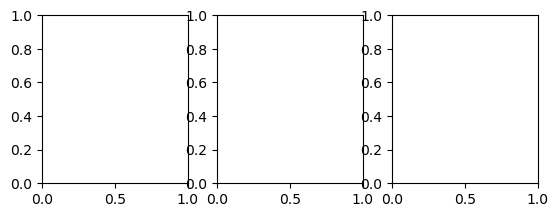

In [24]:
from IPython.display import clear_output
sf3 = train_df
sf3['calendardate'] = pd.to_datetime(sf3['calendardate'])
sf3.head()

#(ticker_list, date_list, investorname_list) = get_sf3_dims(sf)
ticker_list=dim_tickers
date_list=dim_dates
investorname_list=dim_investors


# Create dictionaries for mapping
investor2idx = {investor: idx for idx, investor in enumerate(investorname_list)}
ticker_date2idx = {(ticker, date): idx for idx, (ticker, date) in enumerate([(ticker, date) for ticker in ticker_list for date in date_list])}
ticker2idx = {ticker: idx for idx, ticker in enumerate(ticker_list)}
date2idx = {date: idx for idx, date in enumerate(date_list)}
batch_size = 100

sf3_dataset = SF3Dataset(sf3, investor2idx, ticker2idx, date2idx, ticker_date2idx)
data_loader = DataLoader(sf3_dataset, batch_size=batch_size, shuffle=True)

returns_idx=[returns[idx_date,idx_ticker] for idx_ticker in range (len(dim_tickers)) for idx_date in range(len(dim_dates))]
ratings_idx=[ratings[idx_date,idx_ticker] for idx_ticker in range (len(dim_tickers)) for idx_date in range(len(dim_dates))]

# Hyperparameters
embedding_dim = 2
ticker_embedding_dim = 1
date_embedding_dim = 1
learning_rate = 0.05
weight_decay = 1e-4 # L2 regularization
num_epochs = 100

model = MatrixFactorization(len(investorname_list), embedding_dim, len(ticker_list), len(date_list), ticker_embedding_dim, date_embedding_dim)

#criterion = nn.MSELoss()
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate, weight_decay=weight_decay)
# Training loop
%matplotlib inline
for epoch in range(num_epochs):
    epoch_loss = 0.0
    all_targets = []
    all_predictions = []

    for batch_idx, (investor_indices, stock_indices, date_indices, ticker_date_indeces, targets) in enumerate(data_loader):
        # Convert lists to tensors
        #print(f'investor_indices={investor_indices}')
        #investor_indices = torch.tensor(investor_indices, dtype=torch.long)
        #stock_indices = torch.tensor(stock_indices, dtype=torch.long)
        #date_indices = torch.tensor(date_indices, dtype=torch.long)
        #print(f'eopch={epoch}, batch_idx={batch_idx}, investor_indeces.shape={investor_indices.shape}')
        optimizer.zero_grad()
        predictions = model(investor_indices, stock_indices, date_indices,ticker_date_indeces)
        loss = criterion(predictions, torch.sign(targets))
        all_targets.append(targets)
        all_predictions.append(predictions)


        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()
    #if((epoch%25)==1):
    #    print(f'epoch={epoch}, batch_idx={batch_idx}, loss={loss.item()}')
    #    plot_inv_embeddings()
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(investorname_list)}")
    plot_inv_embeddings()
    clear_output(wait=True)

    #print(f"Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss/len(investorname_list)}")


In [66]:
pref_factor1

array([-1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1., -1.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,
        1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  1.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,
        0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.])

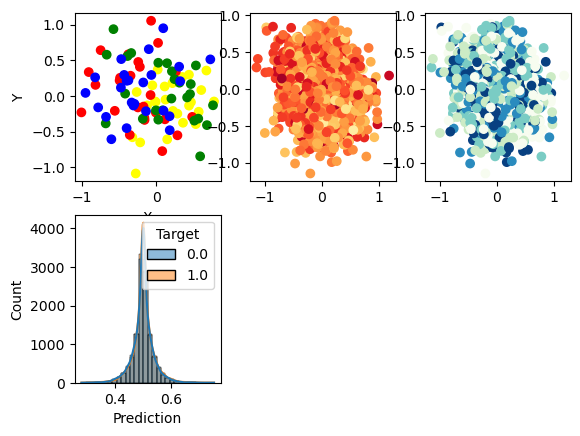

In [20]:

def plot_inv_embeddings():
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    labels=np.zeros(model.investor_embeddings.weight.data.shape[0])

    labels[pref_factor1==-1]=1
    labels[pref_factor1==1]=2
    labels[pref_factor2==-1]=3
    labels[pref_factor2==1]=4
    colors={1:'yellow',2:'red',3:'green',4:'blue'}
    point_colors = [colors[label] for label in labels]


# Generate random 3D embeddings (replace this with your actual embeddings)
    #embeddings = np.random.rand(50, 3)

# Extract the x, y, and z coordinates
    x = model.investor_embeddings.weight.data[:, 0]
    y = model.investor_embeddings.weight.data[:, 1]
    if(embedding_dim>=3):
        z = model.investor_embeddings.weight.data[:, 2]
    else:
        z=np.zeros_like(x)
    #z = model.investor_embeddings.weight.data[:, 2]


    x2 = model.ticker_date_embeddings.weight.data[:, 0]
    y2 = model.ticker_date_embeddings.weight.data[:, 1]
    if(embedding_dim>=3):
        z2 = model.ticker_date_embeddings.weight.data[:, 2]
    else:
        z2=np.zeros_like(x2)
    #z2 = model.ticker_date_embeddings.weight.data[:, 2]
    #z=np.zeros_like(x)

# Create a 3D scatter plot
    fig = plt.figure()
    if(embedding_dim>=3):
        ax = fig.add_subplot(231, projection='3d')
        ax2= fig.add_subplot(232, projection='3d')
        ax3= fig.add_subplot(233, projection='3d')
        ax4= fig.add_subplot(234)
    else:
        ax = fig.add_subplot(231)
        ax2= fig.add_subplot(232)
        ax3= fig.add_subplot(233)
        ax4= fig.add_subplot(234)
    
    #ax = fig.add_subplot(111)
    if(embedding_dim>=3):
        ax.scatter(x, y, z, c=point_colors)
        ax2.scatter(x2, y2, z2, c=returns_idx, cmap='YlOrRd')
        ax3.scatter(x2, y2, z2, c=ratings_idx, cmap='GnBu')
    else:
        ax.scatter(x, y, c=point_colors)
        ax2.scatter(x2, y2, c=returns_idx, cmap='YlOrRd')
        ax3.scatter(x2, y2, c=ratings_idx, cmap='GnBu')
    #ax.scatter(x, y, c=point_colors) 
    all_targets_flat = torch.cat(all_targets)
    all_predictions_flat = torch.cat(all_predictions)
    all_predictions_np = all_predictions_flat.detach().numpy()
    all_targets_np = all_targets_flat.detach().numpy()

    # Create a DataFrame with target and prediction columns
    data = pd.DataFrame({'Target': all_targets_np, 'Prediction': all_predictions_np})
    import seaborn as sns
    sns.histplot(data=data, x='Prediction', hue='Target',kde=True, bins=30, ax=ax4)
# Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    #ax.set_zlabel('Z')

# Show the plot
    plt.show()

plot_inv_embeddings()

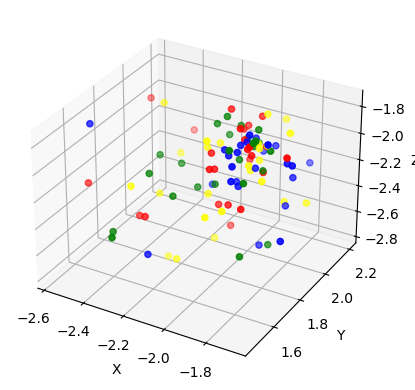

In [19]:
def plot_inv_embeddings():
    model.investor_embeddings.weight.data[51:76,:]
    import matplotlib.pyplot as plt
    from mpl_toolkits.mplot3d import Axes3D
    labels=np.zeros(model.investor_embeddings.weight.data.shape[0])

    labels[pref_factor1==-1]=1
    labels[pref_factor1==1]=2
    labels[pref_factor2==-1]=3
    labels[pref_factor2==1]=4
    colors={1:'blue',2:'green',3:'yellow',4:'red'}
    point_colors = [colors[label] for label in labels]


# Generate random 3D embeddings (replace this with your actual embeddings)
    embeddings = np.random.rand(50, 3)

# Extract the x, y, and z coordinates
    x = model.investor_embeddings.weight.data[:, 0]
    y = model.investor_embeddings.weight.data[:, 1]
    z = model.investor_embeddings.weight.data[:, 2]

# Create a 3D scatter plot
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(x, y, z, c=point_colors)

# Set axis labels
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Show the plot
    plt.show()

plot_inv_embeddings()

In [73]:
model.investor_embeddings.weight.data[0:25,:]

tensor([[-2.0375,  1.7823, -1.9386],
        [-2.3636,  2.5913, -1.4466],
        [-2.4352,  1.6986, -1.8806],
        [-3.8718,  1.8922, -1.3974],
        [-1.3618,  2.3608, -2.1788],
        [-1.5525,  1.8315, -2.3561],
        [-1.8252,  2.3735, -1.7922],
        [-1.6288,  2.1878, -2.2089],
        [-1.9153,  2.3977, -1.6945],
        [-2.0050,  1.8288, -1.6823],
        [-1.9442,  1.7560, -1.6917],
        [-2.2851,  1.5097, -2.0284],
        [-1.9367,  1.7753, -1.7306],
        [-2.4105,  1.9657, -1.6901],
        [-2.2702,  2.3013, -1.3929],
        [-1.5939,  2.2255, -1.8341],
        [-1.7757,  1.7394, -2.0941],
        [-1.5102,  2.9038, -1.5304],
        [-1.6059,  2.7176, -1.6324],
        [-2.3057,  1.1831, -2.9474],
        [-1.5792,  2.2755, -1.8780],
        [-2.3870,  1.1393, -3.1552],
        [-2.5972,  1.5061, -1.5845],
        [-2.4373,  2.3587, -1.6794],
        [-1.7403,  1.8667, -2.3876]])

In [46]:
model.investor_embeddings.weight.data[0:25,:]

tensor([[-1.9514,  1.0076,  1.4024],
        [-1.4460,  1.1431,  1.4033],
        [-1.5909,  1.9541,  0.8572],
        [-0.8154,  1.3899,  2.3816],
        [-1.9872,  0.7791,  1.5959],
        [-3.3301,  0.8554,  1.4285],
        [-1.8795,  1.3176,  1.1129],
        [-1.9273,  1.0895,  1.4016],
        [-1.5793,  1.4738,  0.9430],
        [-1.4417,  1.0064,  1.4576],
        [-2.5381,  0.6992,  2.0121],
        [-0.9370,  1.2608,  1.8920],
        [-1.4195,  0.9134,  1.6382],
        [-2.0376,  0.9546,  1.6842],
        [-1.3556,  0.8575,  2.3476],
        [-2.8019,  1.1747,  0.9849],
        [-1.5546,  1.0290,  1.4608],
        [-1.3083,  1.0272,  1.3910],
        [-1.4960,  0.9021,  1.9737],
        [-1.5490,  1.1196,  1.2777],
        [-1.6120,  0.8658,  2.0019],
        [-1.0831,  1.1104,  2.3068],
        [-1.6731,  1.1057,  1.0532],
        [-0.9304,  1.3711,  2.6248],
        [-1.5811,  0.9619,  1.6419]])

In [54]:
import numpy as np

# Create synthetic data for returns and ratings
#chatGPT generated test function
num_dates = 5
num_stocks = 7
returns = np.random.rand(num_dates, num_stocks)
ratings = np.random.rand(num_dates, num_stocks)

# Number of stocks to pick
num_picks = 3
print(f"returns:\n{returns[0,:]}")
print(f"ratings:\n{ratings[0,:]}")

# Test the function with different preference factors
test_cases = [
    {"pref_factor1": -1, "pref_factor2": 0},
    {"pref_factor1": 1, "pref_factor2": 0},
    {"pref_factor1": 0, "pref_factor2": -1},
    {"pref_factor1": 0, "pref_factor2": 1},
]

for test_case in test_cases:
    pref_factor1 = test_case["pref_factor1"]
    pref_factor2 = test_case["pref_factor2"]
    
    picked_indices = pick_stocks_on_preference(num_picks, pref_factor1, pref_factor2, returns, ratings)
    
    print(f"Preference factors: {pref_factor1} (returns), {pref_factor2} (ratings)")
    print(f"Picked stock indices:\n{picked_indices}")
    print("-" * 40)


returns:
[0.09362876 0.94418965 0.63779439 0.4784309  0.15442046 0.24275315
 0.13164508]
ratings:
[0.61593677 0.50435518 0.34398955 0.51756773 0.14967263 0.11469336
 0.77293415]
num_picks=3,pref_factor1=-1,pref_factor2=0,num_dates=5,num_stocks=7
Preference factors: -1 (returns), 0 (ratings)
Picked stock indices:
[[6. 3. 4.]
 [5. 4. 3.]
 [5. 6. 1.]
 [0. 6. 4.]
 [0. 1. 2.]]
----------------------------------------
num_picks=3,pref_factor1=1,pref_factor2=0,num_dates=5,num_stocks=7
Preference factors: 1 (returns), 0 (ratings)
Picked stock indices:
[[1. 2. 3.]
 [2. 1. 0.]
 [1. 4. 0.]
 [1. 5. 4.]
 [5. 6. 2.]]
----------------------------------------
num_picks=3,pref_factor1=0,pref_factor2=-1,num_dates=5,num_stocks=7
Preference factors: 0 (returns), -1 (ratings)
Picked stock indices:
[[2. 0. 1.]
 [5. 6. 3.]
 [5. 6. 0.]
 [3. 0. 5.]
 [2. 6. 4.]]
----------------------------------------
num_picks=3,pref_factor1=0,pref_factor2=1,num_dates=5,num_stocks=7
Preference factors: 0 (returns), 1 (ratings

In [34]:
a=np.array([1,0,3])
type(np.sign(a)[0])

numpy.int64

ChatGPT rewrite of my paragraph:

In an attempt to build a recommendation system for institutional investors, we aim to use a collaborative filtering approach. Our goal is to predict stock allocations for funds based on their preferences and other influencing factors. We recognize several challenges in applying traditional collaborative filtering to this problem, including the non-stationary nature of stock features, time delays in data reporting, and the differing scales of fund allocations.

To address these challenges, we propose the following approach:

- Synthetic Data Generation:  We will start by generating synthetic data that allows us to test our model on data with known underlying relationships between preferences, returns, and ratings. Our initial iteration will focus on funds that select stocks based on returns or analyst ratings.
- Feature Engineering: Given the dynamic nature of stock features and fund preferences, we will expand our dataset with features like stock valuation metrics, sector or industry information, market cap, past returns, fund size, investment style, and historical performance.
- Model Development: Our approach begins with a simple matrix factorization model, which we will gradually refine to account for the unique characteristics of our problem. This may include adding time-dependent bias terms or exploring advanced models like neural collaborative filtering to capture nonlinear relationships between features.
- Evaluation: Using synthetic data, we will divide our dataset into training, validation, and test sets. This enables us to train our model, tune hyperparameters, and evaluate performance. With synthetic data, we can assess how effectively our model captures the underlying preferences of funds based on returns and ratings.
- Iterative Improvement: We will iteratively improve our model by incorporating additional features, adjusting the model architecture, and addressing unique problem characteristics (e.g., handling delayed data). This iterative process will continue until our model performs reasonably well on synthetic data.
- After successfully refining our model on synthetic data, we will test it on real-world data and make further adjustments as needed to improve performance.